# Predicción de terminación de contratos con el banco

En este proyecto se busca predecir si un cliente dejará pronto el banco. Se utilizará un conjunto de datos sobre el comportamiento pasado de los clientes y su terminación de contratos con el banco. Se generarán distintos modelos buscando el de mayor calidad posible según las métricas de F1. También se determinará el AUC-ROC para el modelo final.

## Información general

In [2]:
#Librerías
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [3]:
df = pd.read_csv('/datasets/Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


## Preprocesamiento de datos

### Valores ausentes

In [5]:
df['Tenure'].value_counts(dropna=False)

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Se encuentran valores ausentes en la columna `Tenure` y su proporción es similar a varias otros valores de la columna.

Se asume que los valores ausentes se deben a clientes que no cuentan con depósito a plazo fijo en el banco y, por tanto, su valor podría ser equivalente a cero. Por lo tanto, se procede a reemplazar de esta forma los valores ausentes.

In [6]:
df['Tenure'] = df['Tenure'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Selección de columnas

De todas las columnas disponibles en el conjunto de datos, se descartan `RowNumber`, `CustomerId` y `Surname` puesto que no son útiles para entrenar los modelos y podrían llevar al sobreajuste.

In [7]:
data = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


### Codificación

Se transforman las características categóricas a numéricas mediante la técnica One-Hot Encoding. Para ello se llama a la función `pd.get_dummies()`.

In [8]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Escalado de características

Puesto que las características tienen diferentes escalas se estandarizan los datos mediante el escalado para que puedan considerarse igualmente importantes en el entrenamiento del modelo.

In [9]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts','EstimatedSalary']
scaler = StandardScaler()
scaler.fit(data_ohe[numeric])

data_ohe[numeric] = scaler.transform(data_ohe[numeric])

data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-0.817441,-1.225848,-0.911583,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,-1.138838,0.117350,-0.911583,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,1.110941,1.333053,2.527057,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,-1.138838,-1.225848,0.807737,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,-0.817441,0.785728,-0.911583,1,1,-0.365276,0,0,1,0


### Segmentación de los datos

Al contar solo con el conjunto de datos fuente se dividirá este en tres partes según la proporción 3:1:1, para los conjuntos de entrenamiento, validación y prueba, respectivamente.

In [10]:
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']

# Primera división del dataset para obtener el conjunto de entrenamiento
features_train, features_rest, target_train, target_rest = train_test_split(
    features, target, test_size=0.4, random_state=12345)

# Segunda división del dataset para obtener los conjuntos de validación y prueba
features_valid, features_test, target_valid, target_test = train_test_split(
    features_rest, target_rest, test_size=0.5, random_state=12345)

In [11]:
# Se comprueba el tamaño de los conjuntos resultantes
print("Tamaño de los conjuntos y su proporción con respecto al conjunto original:")
print("")
print(f"Conjunto de entrenamiento: {len(features_train)}, {len(features_train)/len(df):.1%}")
print(f"Conjunto de validación: {len(features_valid)}, {len(features_valid)/len(df):.1%}")
print(f"Conjunto de prueba: {len(features_test)}, {len(features_test)/len(df):.1%}")
print(f"Conjunto original: {len(df)}, {len(df)/len(df):.1%}")

Tamaño de los conjuntos y su proporción con respecto al conjunto original:

Conjunto de entrenamiento: 6000, 60.0%
Conjunto de validación: 2000, 20.0%
Conjunto de prueba: 2000, 20.0%
Conjunto original: 10000, 100.0%


## Estudio del equilibrio de clases

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

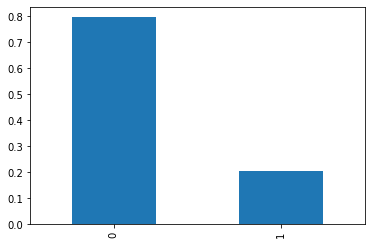

In [12]:
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Se tiene una proporción de clases positivas frente a clases negativas de aproximadamente 1:4, con lo que se puede decir que las clases están desequilibradas.

## Modelos sin tomar en cuenta el desequilibrio

### Árbol de decisión

Se llama a la función DecisionTreeClassifier(). En los hiperparámetros se configura random_state=12345 y en un bucle se prueban distintos valores de max_depth (del 1 al 10) para conocer el que genere el modelo de mayor F1.

In [13]:
best_model_dt = None
best_f1_score_dt = 0
best_depth = 0

for depth in range(1,11):
    
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    f1_score_dt = f1_score(target_valid, predicted_valid)
     
    if f1_score_dt > best_f1_score_dt:
        best_model_dt = model
        best_f1_score_dt = f1_score_dt
        best_depth_dt = depth
print(f"F1 del mejor modelo en el conjunto de validación (max_depth = {best_depth_dt}): {best_f1_score_dt}")

F1 del mejor modelo en el conjunto de validación (max_depth = 9): 0.5786516853932585


### Bosque aleatorio

Se llama a la función RandomForestClassifier(). En los hiperparámetros se configura random_state=12345 y en un bucle anidado se prueban distintos valores de árboles o n_estimatores (del 10 a 50 en pasos de 10) y de max_depth (del 1 al 10) para conocer el que genere el modelo de mayor exactitud.

In [14]:
best_model_rf = None
best_f1_score_rf = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 10): 
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1_score_rf = f1_score(target_valid, predicted_valid) 
        if f1_score_rf > best_f1_score_rf:
            best_model_rf = model
            best_f1_score_rf = f1_score_rf
            best_est = est
            best_depth_rf = depth

print("F1 del mejor modelo en el conjunto de validación:", best_f1_score_rf, "n_estimators:", best_est, "best_depth:", best_depth_rf)


F1 del mejor modelo en el conjunto de validación: 0.5800604229607251 n_estimators: 10 best_depth: 9


### Regresión logística

Se llama a la función LogisticRegression(). Se configura random_state=12345 y solver='liblinear'.

In [15]:
model = LogisticRegression(random_state=12345, solver='liblinear') 
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1_score_lr = f1_score(target_valid, predicted_valid)

print("F1 del modelo de regresión logística en el conjunto de validación:", f1_score_lr)

F1 del modelo de regresión logística en el conjunto de validación: 0.33389544688026984


### Conclusiones

El modelo con el F1 más alto (F1 score= ~0.580) fue el de bosque aleatorio configurado con n_estimators=10 y max_depth=9. Con una pequeña diferencia le sigue el modelo de arbol de decisión (F1 score= ~0.579) configurado con max_depth=9. Por último se encuentra el modelo de regresión logística (F1 score= ~0.334). Se espera mejorar la calidad de los modelos corrigiendo el desequilibrio de clase.

## Mejoramiento de la calidad del modelo

Para corregir el desequilibro de clases se utilizarán dos enfoques: el ajuste de peso de clases y el sobremuestreo. 

### Ajuste de peso de clases

Mediante el ajuste de peso clases se busca equilibrar el peso de la clase de menor frecuencia, en este caso la positiva, con la de mayor frecuencia al especificar `class_weight='balanced'` en los modelos.

Se entrenan nuevamente los modelos incluyendo este parámetro y el valor de los hiperparámetros encontrados en la sección anterior y se obtienen ls valores de F1 para los conjuntos de validación, entrenamiento y prueba de cada modelo.

In [16]:
#Árbol de decisión
model_dt2 = DecisionTreeClassifier(random_state=12345, max_depth=best_depth_dt, class_weight='balanced')
model_dt2.fit(features_train, target_train)
predicted_valid = model_dt2.predict(features_valid)
predicted_train = model_dt2.predict(features_train)
predicted_test = model_dt2.predict(features_test)
f1_score_dt2 = f1_score(target_valid, predicted_valid)
print("F1 del modelo en el conjunto de validación:", f1_score_dt2)
print("F1 del modelo en el conjunto de entrenamiento:", f1_score(target_train, predicted_train))
print("F1 del modelo en el conjunto de prueba:", f1_score(target_test, predicted_test))

F1 del modelo en el conjunto de validación: 0.5338567222767419
F1 del modelo en el conjunto de entrenamiento: 0.6862876254180602
F1 del modelo en el conjunto de prueba: 0.5471877979027645


In [17]:
#Bosque aleatorio
model_rf2 = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth_rf, class_weight='balanced') 
model_rf2.fit(features_train, target_train)
predicted_valid = model_rf2.predict(features_valid)
predicted_train = model_rf2.predict(features_train)
predicted_test = model_rf2.predict(features_test)
f1_score_rf2 = f1_score(target_valid, predicted_valid)
print("F1 del modelo en el conjunto de validación:", f1_score_rf2)
print("F1 del modelo en el conjunto de entrenamiento:", f1_score(target_train, predicted_train))
print("F1 del modelo en el conjunto de prueba:", f1_score(target_test, predicted_test))

F1 del modelo en el conjunto de validación: 0.6035242290748899
F1 del modelo en el conjunto de entrenamiento: 0.72480181200453
F1 del modelo en el conjunto de prueba: 0.5745614035087719


In [18]:
#Regresión logística
model_lr2 = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced') 
model_lr2.fit(features_train, target_train)
predicted_valid = model_lr2.predict(features_valid)
predicted_train = model_lr2.predict(features_train)
predicted_test = model_lr2.predict(features_test)
f1_score_lr2 = f1_score(target_valid, predicted_valid)
print("F1 del modelo de regresión logística en el conjunto de validación:", f1_score_lr2)
print("F1 del modelo de regresión logística en el conjunto de entrenamiento:", f1_score(target_train, predicted_train))
print("F1 del modelo de regresión logística en el conjunto de prueba:", f1_score(target_test, predicted_test))

F1 del modelo de regresión logística en el conjunto de validación: 0.4888888888888888
F1 del modelo de regresión logística en el conjunto de entrenamiento: 0.5
F1 del modelo de regresión logística en el conjunto de prueba: 0.4797238999137188


Los resultados muestran que el modelo de bosque aleatorio y el de regresión logística mejoraron su F1 al realizar el ajuste de peso de clases con el conjunto de validación. Por su lado, el F1 del modelo de árbol de decisión se redujo en comparación al modelo que no toma en cuenta el desequilibrio.

Con respecto a los valores de F1 entre los distintos conjuntos, los resultados muestran que el modelo de árbol de decisión como el de bosque aleatorio tienen un rendimiento consistente en los conjuntos de validación y prueba dado sus valores de F1 cercanos entre sí, lo que indica que el modelo generaliza de manera efectiva a datos no vistos y tiene un rendimiento similar en diferentes conjuntos de evaluación, lo mismo ocurre con el modelo de regresión logística. Sin embargo, las diferencias entre los F1 de los conjuntos de entrenamiento con los F1 de los conjuntos de validación y prueba podría sugerir cierto grado de sobreajuste. En el modelo de regresión logística, esta diferencia es más pequeña, lo que indica que generaliza adecuadamente dentro de su nivel de rendimiento.

### Sobremuestreo

En vista de que la proporción de clases positivas frente a las clases negativas es de 1:4 aproximadamente, se utilizará el sobremuestreo para multiplicar la ocurrencia de clases positivas por 4 para igualar su frecuencia.

In [19]:
def upsample(features, target, repeat):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(
    features_train, target_train, 4)

A continuación, se aplica el sobremuestreo en cada uno de los modelos.

In [20]:
#Árbol de decisión
model_dt3 = DecisionTreeClassifier(random_state=12345, max_depth=best_depth_dt)
model_dt3.fit(features_upsampled, target_upsampled)
predicted_valid = model_dt3.predict(features_valid)
predicted_train = model_dt3.predict(features_train)
predicted_test = model_dt3.predict(features_test)
f1_score_dt3 = f1_score(target_valid, predicted_valid)
print("F1 del modelo en el conjunto de validación:", f1_score_dt3)
print("F1 del modelo en el conjunto de entrenamiento:", f1_score(target_train, predicted_train))
print("F1 del modelo en el conjunto de prueba:", f1_score(target_test, predicted_test))

F1 del modelo en el conjunto de validación: 0.5304518664047152
F1 del modelo en el conjunto de entrenamiento: 0.6863073317710077
F1 del modelo en el conjunto de prueba: 0.5487571701720841


In [21]:
#Bosque aleatorio
model_rf3 = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth_rf) 
model_rf3.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf3.predict(features_valid)
predicted_train = model_rf3.predict(features_train)
predicted_test = model_rf3.predict(features_test)
f1_score_rf3 = f1_score(target_valid, predicted_valid)
print("F1 del modelo en el conjunto de validación:", f1_score_rf3)
print("F1 del modelo en el conjunto de entrenamiento:", f1_score(target_train, predicted_train))
print("F1 del modelo en el conjunto de prueba:", f1_score(target_test, predicted_test))

F1 del modelo en el conjunto de validación: 0.6063829787234043
F1 del modelo en el conjunto de entrenamiento: 0.7402833272793315
F1 del modelo en el conjunto de prueba: 0.5905759162303664


In [22]:
#Regresión logística
model_lr3 = LogisticRegression(random_state=12345, solver='liblinear') 
model_lr3.fit(features_upsampled, target_upsampled)
predicted_valid = model_lr3.predict(features_valid)
predicted_train = model_lr3.predict(features_train)
predicted_test = model_lr3.predict(features_test)
f1_score_lr3 = f1_score(target_valid, predicted_valid)

print("F1 del modelo de regresión logística en el conjunto de validación:", f1_score_lr3)
print("F1 del modelo de regresión logística en el conjunto de entrenamiento:", f1_score(target_train, predicted_train))
print("F1 del modelo de regresión logística en el conjunto de prueba:", f1_score(target_test, predicted_test))

F1 del modelo de regresión logística en el conjunto de validación: 0.4888888888888888
F1 del modelo de regresión logística en el conjunto de entrenamiento: 0.4997043169722058
F1 del modelo de regresión logística en el conjunto de prueba: 0.4779220779220779


El sobremuestreo produjo un ligero aumento del F1 para el modelo de bosque aleatorio con el conjunto de validación, mientras que para el modelo de árbol de decisión el F1 se redujo y para el modelo de regresión logística se mantuvo igual. Por lo tanto, solo existieron mejoras para el modelo de bosque aleatorio.

Por su lado, los F1 entre los distintos conjuntos siguen el mismo comportamiento que con el caso del ajuste de pesos, el rendimiento es consistente entre los conjuntos de validación y prueba debido a sus F1 similares, mientras que su diferencia con los F1 de los conjuntos de entrenamiento sugieren cierto sobreajuste en los modelos de árbol de decisión y bosque aleatorio. La brecha sigue siendo menor en el caso del modelo de regresión logística. 



### Resumen

Se crea una tabla que resume los resultados obtenidos con el conjunto de validación.

In [23]:
f1_scores = {
    'Modelo': ['Árbol de decisión', 'Bosque aleatorio', 'Regresión logística'],
    'Desequilibrado': [best_f1_score_dt, best_f1_score_rf, f1_score_lr],
    'Ajuste de peso de clases': [f1_score_dt2, f1_score_rf2, f1_score_lr2],
    'Sobremuestreo': [f1_score_dt3, f1_score_rf3, f1_score_lr3]
}


f1_scores_df = pd.DataFrame(f1_scores)


f1_scores_df.set_index('Modelo', inplace=True)


f1_scores_df

,Desequilibrado,Ajuste de peso de clases,Sobremuestreo
Modelo,,,
Árbol de decisión,0.578652,0.533857,0.530452
Bosque aleatorio,0.580060,0.603524,0.606383
Regresión logística,0.333895,0.488889,0.488889


Los resultados indican que ambos enfoques para corregir el desequilibrio de clases aumentaron el F1 en los modelos de bosque aleatorio y de regresión logística. Para el modelo de árbol de decisión, ambos enfoques redujeron el F1. En el modelo de regresión logística, ambos enfoques aumentaron el F1 en la misma medida. El sobremuestreo en el modelo de bosque aleatorio produjo el mayor F1 de todos los modelos.

## Comprobación de la calidad del mejor modelo con el conjunto de prueba

Al haber determinado el modelo con el mayor F1 (bosque aleatorio con sobremuestreo), se procede a evaluarlo con el conjunto de prueba que se segmentó anteriormente. Se obtiene también el valor de AUC-ROC.

In [24]:
# Se concatenan los conjuntos de entrenamiento y validación
features_train_final=pd.concat([features_train] + [features_valid])
target_train_final=pd.concat([target_train] + [target_valid])

# Se realiza el sobremuestreo del conjunto final
features_upsampled, target_upsampled = upsample(
    features_train_final, target_train_final, 4)

# Se entrena el modelo y se obtiene F1
final_model = RandomForestClassifier(random_state=12345, max_depth=best_depth_rf, n_estimators=best_est)
final_model.fit(features_upsampled, target_upsampled)
predicted_test = final_model.predict(features_test)
f1_score_final = f1_score(target_test, predicted_test)
print("F1 del modelo en el conjunto de prueba:", f1_score_final)

#Se obtiene la probabilidad de clase y AUC-ROC
probabilities_test = final_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print("AUC-ROC score:", auc_roc)

F1 del modelo en el conjunto de prueba: 0.5905759162303664
AUC-ROC score: 0.841482390929901


Finalmente, se grafica la curva ROC para observar cómo varía la capacidad del modelo para distinguir entre las clases positiva y negativa a medida que se ajusta el umbral de clasificación.

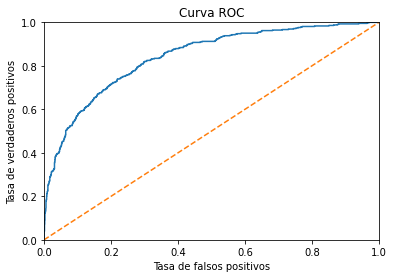

In [25]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

El F1 obtenido finalmente es de ~0.591, el cual es aceptable. El valor de AUC-ROC indica que el modelo tiene una buena capacidad para distinguir entre las clases positiva y negativa. Es decir, el modelo es capaz de clasificar correctamente una muestra aleatoria positiva en lugar de una negativa en un ~84% de los casos.

Por su lado, la gráfica indica que el modelo tiene en general una buena sensibilidad (TPR) y una baja tasa de falsos positivos (FPR). Ya que la curva se acerca al ángulo superior izquierdo del gráfico y, como indica el valor AUC-ROC, se puede concluir que el modelo tiene un buen rendimiento. 